In [359]:
import json
import pandas as pd
import torch.nn as nn
import torch
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cpu'
device

'cpu'

In [360]:
jsonl_file_path = 'clips_dataset_wth_herbert_token_ids.jsonl'


In [361]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# Assuming CUDA is available, models and data will be moved to GPU for faster processing.
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
input_size = 33 * 3  # 33 joints * 3 coordinates
hidden_size = 256
output_size = 50000 # Assuming a vocabulary size of 66
embedding_size = 256  # Make embedding size equal to hidden_size for simplicity
SOS_token = 0  # Start-of-Sequence token

In [362]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1}
        self.word2count = {"SOS": 0, "EOS": 0}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2   # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

class SignLanguage:
    def __init__(self):
        self.frames = []
        self.max_length = 0

    def addFrames(self, frame_data):
        self.frames.append(frame_data)
        if len(frame_data) > self.max_length:
            self.max_length = len(frame_data)

    def getFrames(self):
        return self.frames


In [363]:
def prepareData(jsonl_file_path, max_samples=1000, split_ratio=0.8):
    data = []
    with open(jsonl_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
            if len(data) >= max_samples:
                break

    random.shuffle(data)
    split_point = int(len(data) * split_ratio)
    training_data = data[:split_point]
    testing_data = data[split_point:]

    def processData(data):
        sign_language = SignLanguage()
        lang_annotations = Lang('pl')
        for item in data:
            sign_language.addFrames(item['FramesLandmarksCoords'])
            lang_annotations.addSentence(item['PolishAnnotation'])
        return sign_language, lang_annotations, [(item['FramesLandmarksCoords'], item['PolishAnnotation']) for item in data]

    return processData(training_data), processData(testing_data)


In [364]:
training_dataset, testing_dataset = prepareData(jsonl_file_path, max_samples=1000)

# Unpack the training dataset
train_sign_language, train_polish_annotations, train_pairs = training_dataset

# Unpack the testing dataset
test_sign_language, test_polish_annotations, test_pairs = testing_dataset

print(f"Loaded {len(train_pairs)} pairs of sign language frames and Polish annotations.")

Loaded 800 pairs of sign language frames and Polish annotations.


In [365]:
EOS_token = train_polish_annotations.word2index['EOS']

In [366]:
if 'EOS' not in train_polish_annotations.word2index:
    train_polish_annotations.addWord('EOS')

In [367]:
def tensorsFromPair(pair, annotations):
    # Attempt to handle a variety of data structures defensively
    try:
        # Flatten the frame data correctly, assuming it's deeply nested
        flat_list = [coord for frame in pair[0] for landmark in frame for coord in (landmark if isinstance(landmark, list) else [landmark])]
    except TypeError:
        # If there's a type error, log the problematic data and skip or handle appropriately
        print("Error processing pair:", pair)
        flat_list = []

    # Now, calculate the dimensions based on the corrected flat list
    if flat_list:
        input_tensor = torch.tensor(flat_list, dtype=torch.float).view(-1, len(flat_list) // len(pair[0]))  # Adjust based on actual data length
    else:
        # Handle the error case (e.g., return a dummy tensor or skip this pair)
        input_tensor = torch.tensor([], dtype=torch.float).view(-1, 1)  # Dummy tensor, adjust as needed

    # Process target indexes
    target_indexes = [annotations.word2index[word] for word in pair[1].split(' ')] + [EOS_token]
    target_tensor = torch.tensor(target_indexes, dtype=torch.long)

    return (input_tensor, target_tensor)

from torch.nn.utils.rnn import pad_sequence

def get_dataloader(pairs, batch_size, annotations):
    input_tensors = []
    target_tensors = []

    for pair in pairs:
        input_tensor, target_tensor = tensorsFromPair(pair, annotations)
        input_tensors.append(input_tensor)
        target_tensors.append(target_tensor)

    # Pad sequences to have the same length within each tensor
    # Note: pad_sequence automatically pads to the longest sequence in each batch
    input_tensors_padded = pad_sequence(input_tensors, batch_first=True, padding_value=0)
    target_tensors_padded = pad_sequence(target_tensors, batch_first=True, padding_value=annotations.word2index['EOS'])  # Assuming 'EOS' token is used as padding

    dataset = TensorDataset(input_tensors_padded, target_tensors_padded)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


In [368]:
batch_size = 64

data_loader = get_dataloader(train_pairs, batch_size, train_polish_annotations)
data_loader_test = get_dataloader(test_pairs, batch_size, test_polish_annotations)

print(f"DataLoader prepared with batch size: {batch_size}")

DataLoader prepared with batch size: 64


In [369]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # Applying dropout to the input might not be directly applicable if input is continuous.
        # Consider applying dropout after GRU if needed or using it in a different manner.
        output, hidden = self.gru(input)
        return output, hidden

In [370]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(37):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None and i < target_tensor.size(1) - 1:
            # Teacher forcing: Feed the target as the next input, ensuring we don't exceed target_tensor's length
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [371]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        query = query.float()
        keys = keys.float()
        scores = self.Va(torch.tanh(self.Wa(query.expand(-1, keys.size(1), -1)) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights


class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(37):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [372]:
input_size = 33 * 3  # Assuming each frame is represented by 33 landmarks, each with 3 coordinates
hidden_size = 256  # Example hidden size, adjust based on model complexity and dataset
output_size = len(train_polish_annotations.word2index)  # Assuming polish_annotations is your output language object
dropout_p = 0.1  # Dropout probability

encoder = EncoderRNN(input_size, hidden_size, dropout_p).to(device)
decoder = AttnDecoderRNN(hidden_size, output_size, dropout_p).to(device)

# Example of model initialization
print(encoder)
print(decoder)

EncoderRNN(
  (gru): GRU(99, 256, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)
AttnDecoderRNN(
  (embedding): Embedding(2422, 256)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=256, out_features=256, bias=True)
    (Ua): Linear(in_features=256, out_features=256, bias=True)
    (Va): Linear(in_features=256, out_features=1, bias=True)
  )
  (gru): GRU(512, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=2422, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [373]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    encoder.train()
    decoder.train()

    total_loss = 0
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)  # Move to the correct device
        target_tensor = target_tensor.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [374]:
encoder_optimizer = optim.SGD(encoder.parameters(), lr=0.0001)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=0.0001)
criterion = nn.NLLLoss().to(device)

In [375]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [376]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    print(plot_losses)

    showPlot(plot_losses)

1m 20s (- 0m 0s) (1 100%) 1.3960
[1.3959516745347242]


<Figure size 640x480 with 0 Axes>

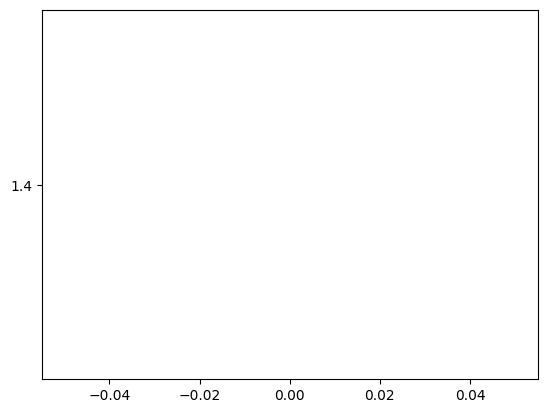

In [378]:
train(data_loader, encoder, decoder, 1, print_every=1, plot_every=1)

In [412]:
def evaluate(encoder, decoder, dataloader):
    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

            _, topi = decoder_outputs.topk(1)
            decoded_ids = topi.squeeze()

            decoded_words = []
            for idx in decoded_ids:
                # if idx.item() == EOS_token:
                #     decoded_words.append('<EOS>')
                #     break
                decoded_words.append(idx)
        return decoded_words, decoder_attn


In [410]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, data_loader)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [413]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> [[[0.5536189675331116, 0.3297105431556701, -0.2009197920560836], [0.5612958669662476, 0.2875800728797912, -0.1714861392974853], [0.5654477477073669, 0.287899911403656, -0.1716196984052658], [0.5687261819839478, 0.287930279970169, -0.1717343479394912], [0.5426627993583679, 0.2843984961509704, -0.2059215605258941], [0.5329124331474304, 0.2825249135494232, -0.2058753073215484], [0.522026538848877, 0.2785196006298065, -0.2061782777309417], [0.556364893913269, 0.2862173616886139, 0.0174603052437305], [0.4932738244533539, 0.2749283015727997, -0.1363002657890319], [0.551327645778656, 0.3666074573993683, -0.1242715939879417], [0.5301374197006226, 0.3626702129840851, -0.1691399365663528], [0.5812806487083435, 0.4469992816448211, 0.0904628336429596], [0.4046181738376617, 0.4621069729328155, -0.1098103299736976], [0.6790358424186707, 0.7130624651908875, 0.0002617332502268], [0.4710938334465027, 0.7446014285087585, -0.2050987929105758], [0.5687495470046997, 0.7138242125511169, -0.215858250856399

TypeError: sequence item 0: expected str instance, Tensor found